In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image

## Data

In [3]:
label_index = {"dry": 0, "normal": 1, "oily": 2}

def create_df(base):
    dd = {"images": [], "labels": []}
    for label_name in os.listdir(base):
        label_path = os.path.join(base, label_name)
        if os.path.isdir(label_path):  
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                dd["images"].append(img_path)
                dd["labels"].append(label_index[label_name])
    return pd.DataFrame(dd)

In [4]:
train_path = "Skin_Type_Classification/Oily-Dry-Skin_Faces_only/train"
train_df = create_df(train_path)
valid_path = "Skin_Type_Classification/Oily-Dry-Skin_Faces_only/valid"
valid_df = create_df(valid_path)

In [5]:
def load_image_rgb(image_path):
    with Image.open(image_path) as img:
        return img.convert("RGB")


In [6]:
def open_data(df):
    images = []
    
    for index, row in df.iterrows():
        img = Image.open(row['images']).convert('RGB')
        img = np.array(img) / 255.0
        images.append(img)

    return images

train_data = open_data(train_df)
valid_data = open_data(valid_df)

In [7]:
train_data = np.array(train_data)
valid_data = np.array(valid_data)
train_data.shape

(2756, 650, 650, 3)

In [8]:
train_label = train_df['labels']
valid_label = valid_df['labels']

In [9]:
train_label.shape

(2756,)

In [10]:
from tensorflow.keras.utils import to_categorical
train_label = to_categorical(train_label, num_classes=3)
valid_label = to_categorical(valid_label, num_classes=3)

In [11]:
test_path = "Skin_Type_Classification/Oily-Dry-Skin_Faces_only/test"
test_df = create_df(test_path)
test_data = open_data(test_df)
test_data = np.array(test_data)
test_label = test_df['labels']
test_label = to_categorical(test_label, num_classes=3)

In [12]:
train_data = np.concatenate((train_data, test_data), axis=0)
train_label = np.concatenate((train_label, test_label), axis=0)
train_data.shape

(2890, 650, 650, 3)

In [13]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(train_data, train_label, test_size=0.2, random_state=42, stratify=train_label)

In [14]:
train_data.shape

(2312, 650, 650, 3)

In [15]:
test_label.shape

(578, 3)

## CNN Models

In [16]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, SeparableConv2D, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import History
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

In [17]:
def train_and_evaluate_model(model: Model, train_data, train_label, valid_data, valid_label, test_data, test_label, epochs=10, batch_size=32):
    # Train the model and capture the history
    history = model.fit(
        train_data, 
        train_label, 
        epochs=epochs, 
        batch_size=batch_size
    )
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'bo-', label='Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'bo-', label='Training accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    test_loss, test_accuracy = model.evaluate(test_data, test_label)
    
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

### Model 1

In [28]:
K.clear_session()

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(650, 650, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

model.add(Dense(3, activation='softmax'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 648, 648, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 648, 648, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 324, 324, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 322, 322, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 322, 322, 64)     256       
 hNormalization)                                                 
                                                        

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/20
73/73 [==============================] - 214s 3s/step - loss: 1.1379 - accuracy: 0.3910
Epoch 2/20
73/73 [==============================] - 198s 3s/step - loss: 1.0788 - accuracy: 0.4256
Epoch 3/20
73/73 [==============================] - 198s 3s/step - loss: 1.0857 - accuracy: 0.4174
Epoch 4/20
73/73 [==============================] - 198s 3s/step - loss: 1.0718 - accuracy: 0.4351
Epoch 5/20
73/73 [==============================] - 197s 3s/step - loss: 1.0714 - accuracy: 0.4178
Epoch 6/20
73/73 [==============================] - 197s 3s/step - loss: 1.0740 - accuracy: 0.4243
Epoch 7/20
73/73 [==============================] - 197s 3s/step - loss: 1.0646 - accuracy: 0.4118
Epoch 8/20
73/73 [==============================] - 197s 3s/step - loss: 1.0586 - accuracy: 0.4390
Epoch 9/20
73/73 [==============================] - 196s 3s/step - loss: 1.0619 - accuracy: 0.4351
Epoch 10/20
73/73 [==============================] - 197s 3s/step - loss: 1.0573 - accuracy: 0.4438
Epoch 11/

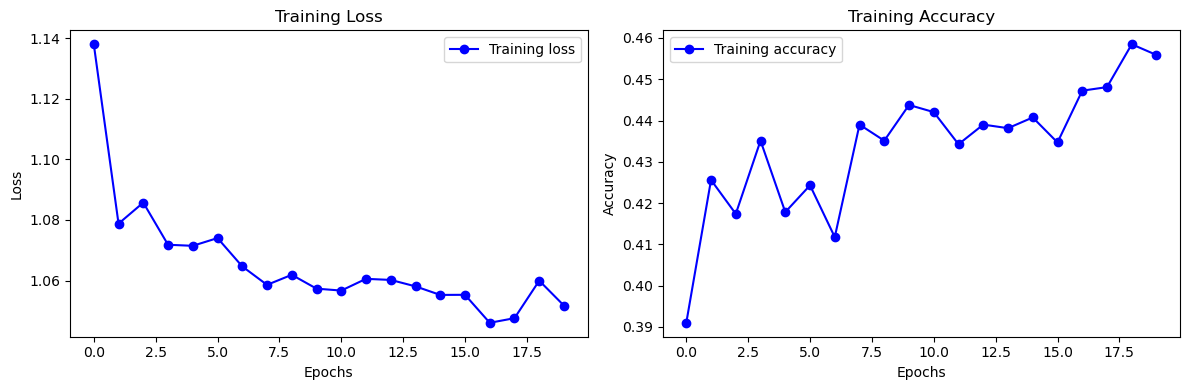

19/19 [==============================] - 11s 572ms/step - loss: 1.3759 - accuracy: 0.3616
Test Loss: 1.3758819103240967
Test Accuracy: 0.3615916967391968


In [31]:
train_and_evaluate_model(model, train_data, train_label, valid_data, valid_label, test_data, test_label, epochs=20, batch_size=32)

### Model 2

In [32]:
K.clear_session()

model = Sequential()

model.add(Conv2D(32, (4, 4), activation='relu', input_shape=(650, 650, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(3, activation='softmax'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 647, 647, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 323, 323, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 320, 320, 64)      32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 160, 160, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 158, 158, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 79, 79, 128)      0

In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/20
73/73 [==============================] - 190s 2s/step - loss: 1.2083 - accuracy: 0.3910
Epoch 2/20
73/73 [==============================] - 173s 2s/step - loss: 1.0756 - accuracy: 0.4273
Epoch 3/20
73/73 [==============================] - 173s 2s/step - loss: 1.0436 - accuracy: 0.4420
Epoch 4/20
73/73 [==============================] - 173s 2s/step - loss: 0.9605 - accuracy: 0.5260
Epoch 5/20
73/73 [==============================] - 173s 2s/step - loss: 0.7745 - accuracy: 0.6458
Epoch 6/20
73/73 [==============================] - 174s 2s/step - loss: 0.5405 - accuracy: 0.7738
Epoch 7/20
73/73 [==============================] - 174s 2s/step - loss: 0.3527 - accuracy: 0.8629
Epoch 8/20
73/73 [==============================] - 173s 2s/step - loss: 0.2130 - accuracy: 0.9234
Epoch 9/20
73/73 [==============================] - 173s 2s/step - loss: 0.1542 - accuracy: 0.9567
Epoch 10/20
73/73 [==============================] - 174s 2s/step - loss: 0.0861 - accuracy: 0.9758
Epoch 11/

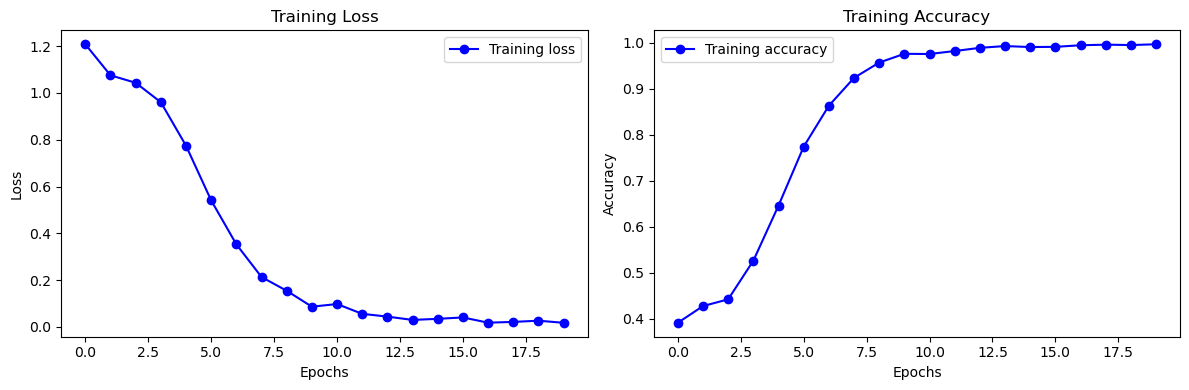

19/19 [==============================] - 11s 511ms/step - loss: 3.2122 - accuracy: 0.6401
Test Loss: 3.2122442722320557
Test Accuracy: 0.6401383876800537


In [35]:
train_and_evaluate_model(model, train_data, train_label, valid_data, valid_label, test_data, test_label, epochs=20, batch_size=32)

### Model 3

In [44]:
from tensorflow.keras.layers import Add, Input, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

K.clear_session()

def residual_block(x, filters, kernel_size=3, strides=1):
    shortcut = x
    if strides != 1 or K.int_shape(x)[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same', strides=strides)(x)
    x = Conv2D(filters, kernel_size, padding='same', strides=strides, activation='relu')(x)
    x = Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

inputs = Input(shape=(650, 650, 3))

x = Conv2D(64, (7, 7), padding='same', strides=2, activation='relu')(inputs)
x = MaxPooling2D((3, 3), strides=2)(x)

x = residual_block(x, 64)
x = residual_block(x, 64)

x = residual_block(x, 128, strides=2)
x = residual_block(x, 128)

x = residual_block(x, 256, strides=2)
x = residual_block(x, 256)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)

model = Model(inputs, outputs)

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 650, 650, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 325, 325, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 162, 162, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [46]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/20
73/73 [==============================] - 259s 3s/step - loss: 4.1792 - accuracy: 0.3798
Epoch 2/20
73/73 [==============================] - 248s 3s/step - loss: 1.0808 - accuracy: 0.3793
Epoch 3/20
73/73 [==============================] - 245s 3s/step - loss: 1.0809 - accuracy: 0.4001
Epoch 4/20
73/73 [==============================] - 246s 3s/step - loss: 1.0777 - accuracy: 0.4022
Epoch 5/20
73/73 [==============================] - 248s 3s/step - loss: 1.0771 - accuracy: 0.4022
Epoch 6/20
73/73 [==============================] - 249s 3s/step - loss: 1.0760 - accuracy: 0.4022
Epoch 7/20
73/73 [==============================] - 247s 3s/step - loss: 1.0762 - accuracy: 0.4022
Epoch 8/20
73/73 [==============================] - 249s 3s/step - loss: 1.0769 - accuracy: 0.4022
Epoch 9/20
73/73 [==============================] - 250s 3s/step - loss: 1.0764 - accuracy: 0.4022
Epoch 10/20
73/73 [==============================] - 249s 3s/step - loss: 1.0762 - accuracy: 0.4022
Epoch 11/

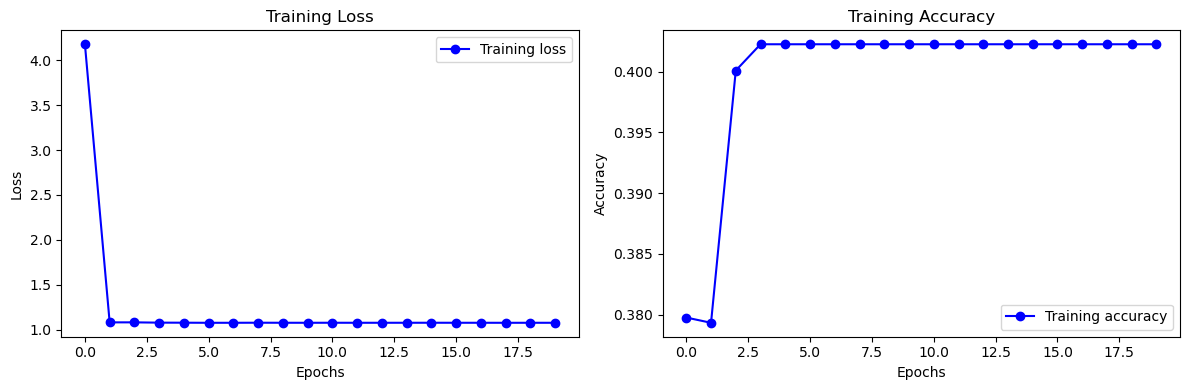

19/19 [==============================] - 16s 701ms/step - loss: 1.0753 - accuracy: 0.4031
Test Loss: 1.07526695728302
Test Accuracy: 0.4031141996383667


In [47]:
train_and_evaluate_model(model, train_data, train_label, valid_data, valid_label, test_data, test_label, epochs=20, batch_size=32)

### Model 4

In [48]:
from tensorflow.keras.layers import Concatenate

K.clear_session()

def inception_module(x, filters):
    conv1x1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    
    conv3x3 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv3x3)
    
    conv5x5 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters, (5, 5), padding='same', activation='relu')(conv5x5)
    
    pool_proj = MaxPooling2D((3, 3), strides=1, padding='same')(x)
    pool_proj = Conv2D(filters, (1, 1), padding='same', activation='relu')(pool_proj)
    
    output = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, pool_proj])
    return output

inputs = Input(shape=(650, 650, 3))

x = Conv2D(32, (7, 7), padding='same', strides=2, activation='relu')(inputs)
x = MaxPooling2D((3, 3), strides=2)(x)

x = inception_module(x, 32)
x = inception_module(x, 64)
x = MaxPooling2D((3, 3), strides=2)(x)

x = inception_module(x, 128)
x = inception_module(x, 256)
x = MaxPooling2D((3, 3), strides=2)(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)

model = Model(inputs, outputs)


In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 650, 650, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 325, 325, 32  4736        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 162, 162, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [50]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/20
73/73 [==============================] - 527s 7s/step - loss: 1.5266 - accuracy: 0.3849
Epoch 2/20
73/73 [==============================] - 503s 7s/step - loss: 1.0771 - accuracy: 0.4148
Epoch 3/20
73/73 [==============================] - 502s 7s/step - loss: 1.0719 - accuracy: 0.3992
Epoch 4/20
73/73 [==============================] - 503s 7s/step - loss: 1.0585 - accuracy: 0.4208
Epoch 5/20
73/73 [==============================] - 501s 7s/step - loss: 1.0370 - accuracy: 0.4485
Epoch 6/20
73/73 [==============================] - 502s 7s/step - loss: 1.0130 - accuracy: 0.4797
Epoch 7/20
73/73 [==============================] - 500s 7s/step - loss: 0.9698 - accuracy: 0.5264
Epoch 8/20
73/73 [==============================] - 503s 7s/step - loss: 0.9007 - accuracy: 0.5688
Epoch 9/20
73/73 [==============================] - 503s 7s/step - loss: 0.7967 - accuracy: 0.6298
Epoch 10/20
73/73 [==============================] - 501s 7s/step - loss: 0.6877 - accuracy: 0.6825
Epoch 11/

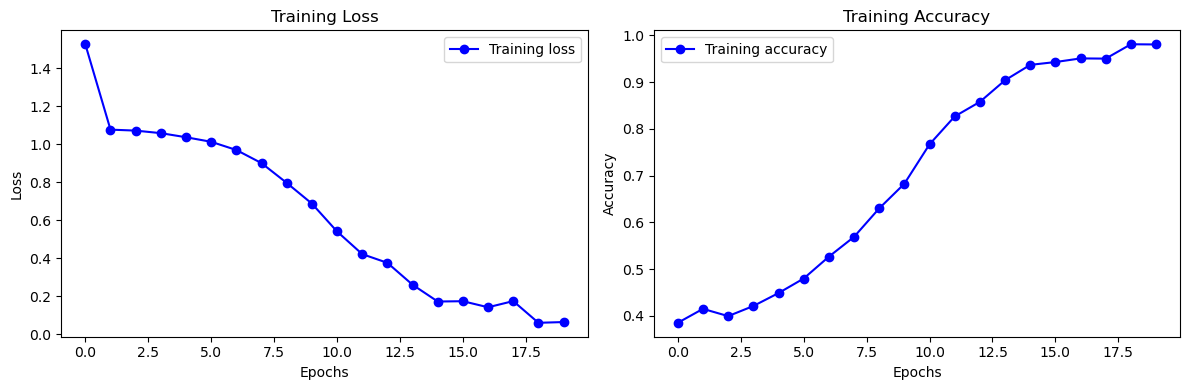

19/19 [==============================] - 33s 2s/step - loss: 3.0333 - accuracy: 0.6851
Test Loss: 3.03328013420105
Test Accuracy: 0.6851211190223694


In [51]:
train_and_evaluate_model(model, train_data, train_label, valid_data, valid_label, test_data, test_label, epochs=20, batch_size=32)